# Tau PT Regression + JetID Classification Merge

In this notebook we will implement a NN that merges the regression and classification NN that we developed for pT regression and jetID, respectively.

In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib
from keras import optimizers


import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.pyplot import cm
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

model_name = '../models/merged_pt_regress_jet_ID.h5'

2023-06-28 10:34:50.457165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 10:34:50.603764: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-28 10:34:50.607585: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-28 10:34:50.607603: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

# Create training/testing data set

The important aspect of $\tau$ leptons is that a $\tau$ can decay to neutrinos, and either an electron and a neutrino, a muon and a neutrino, or quarks. Electrons, muons and quarks can be reconstructed in a collider detector. However, the neutrinos cannot. Neutrinos are very weakly interacting and they will just escape the detector. 

The one constraint we have for neutrinos is what we call missing transverse energy. Missing transverse energy is a constraint that originates from the fact that when we collider protons along a specific axis, the momentum transverse to that axis is conserved, or in other words. 

$$
\begin{equation}
\sum_{i=1}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} + \sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\rm{\vec{MET}}  = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\end{equation}
$$

This is what we call the MET or missing transverse energy. This is our only constraint on the neutrinos and it gives us a vector in the plane perpendicular to the collision axis along the beam.  

Here, instead of training directly for the tau's gen (truth) pT, we want to train for the ratio between the reconstructed pT and the gen pT. This is because the range of pT is so large that it makes training very uneffective. If we train for the ratio, we constrain the output better and the network is more likely to converge. It is also unitless, which means that if there is an invrance against momentum, like lorentz invariance, we can capture it in this quantity  

A technical detail here is the fact that the tau gen $p_T$ here does not include the neutrino's $p_T$.

In [2]:
# #You only need to run this once
# def create_training_data_pT_regression(dir_path, test_index=400000):
#     '''
#     test_index: 400000 
#     All the data before test_index are used for training. And all the data after it is used for testing.
#     '''
    
#     #Might have to change the version for other ntuple files
#     data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    
#     inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
#     print(inputs)
#     truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[:test_index]
#     reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[:test_index]
#     deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[:test_index]
#     eta = data['ntuplePupSingle']['tree']['geneta1'].array()[:test_index]
#     selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
#     #Inputs: pt, eta, phi, particle id(one hot encoded)
#     X_train = np.nan_to_num(np.asarray(inputs[selection]))
#     y_train = np.asarray(truth_pt[selection]/reco_pt[selection])
    
#     X_train[abs(X_train) > 1e+9] = 0.

#     np.save(dir_path+"/X_train.npy", X_train)
#     np.save(dir_path+"/y_train.npy", y_train)
# print(create_training_data_pT_regression("../../ntuples/Jan_25_2023"))
# X_train_pT_regress = np.load("../../ntuples/Jan_25_2023/X_train.npy")
# y_train_pT_regress = np.load("../../ntuples/Jan_25_2023/y_train.npy")
# print(X_train_pT_regress)
# print(y_train_pT_regress)

In [3]:
# def make_weights(sig_pt, reco_bkg_pt, pt_edges = [20,25,30,35,40,45,50,55,60,70,80,100,125,150,2000]):
    
#     weight_pt_bkg = np.zeros(reco_bkg_pt.shape)
    
#     sig_hist, sig_bin_edges = np.histogram(sig_pt, bins = pt_edges)
#     bkg_hist, bkg_bin_edges = np.histogram(reco_bkg_pt, bins = pt_edges)
    
#     scale_factor = [sig_hist[i]/bkg_hist[i] for i in range(len(sig_bin_edges)-1)]
    
#     #Assign the weights to qcd jets
#     for i in range(len(sig_bin_edges)-1):
#         weight_pt_bkg[(reco_bkg_pt >= sig_bin_edges[i]) & (reco_bkg_pt < sig_bin_edges[i+1])] = scale_factor[i]
    
#     #weight_pt_bkg[reco_bkg_pt > 100] = weight_pt_bkg[reco_bkg_pt > 100]/2. #Give less weights for high pT background (v4)
    
#     weight_pt_sig = np.ones(sig_pt.shape)
#     weight_pt_sig[sig_pt > 100.] = 2 #Give more importance to high pT signal (v2 + v3)
# #     weight_pt_sig[sig_pt > 120.] = 5. #Give more importance to high pT signal (v3)
#     all_weight = np.concatenate([weight_pt_sig, weight_pt_bkg])
    
#     return all_weight

# def create_training_data_jetID(dir_path):
    
#     pt_edges = [20,25,30,35,40,45,50,55,60,70,80,100,125,150,2000]
    
#     #Might have to change the version for other ntuple files
#     sig = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
#     bkg = uproot4.open(dir_path+"/test_bkg_v12_emseed.root")
#     qcd = uproot4.open(dir_path+"/test_qcd_v12_emseed.root")
    
#     sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:400000]
#     bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[:400000]
#     qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()
    
#     truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[:400000])
#     truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[:400000])
#     truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())
    
#     reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[:400000]
#     deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:400000]
#     eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:400000]
#     #selection_sig = (truth_pt_sig > 20.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
#     selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
#     y_sig_pT = truth_pt_sig[selection_sig]
    
#     reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[:400000]
#     selection_bkg = reco_pt_bkg > 20.
#     y_bkg_pT = truth_pt_bkg[selection_bkg]
    
#     reco_pt_qcd = qcd['ntuplePupSingle']['tree']['pt'].array()
#     selection_qcd = reco_pt_qcd > 20.
#     y_qcd_pT = truth_pt_qcd[selection_qcd]
    
#     #Maybe better to use 2.4 for eta
    
#     #Inputs: pt, eta, phi, particle id(one hot encoded)
#     X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
#     y_sig = np.full(X_sig.shape[0], 1.)
#     sig_pt = np.asarray(reco_pt_sig[selection_sig])
    
#     X_bkg = np.nan_to_num(np.asarray(bkg_input)[selection_bkg])
#     y_bkg = np.full(X_bkg.shape[0], 0.)
#     bkg_pt = np.asarray(reco_pt_bkg[selection_bkg])
    
#     X_qcd = np.nan_to_num(np.asarray(qcd_input)[selection_qcd])
#     y_qcd = np.full(X_qcd.shape[0], 0.)
#     qcd_pt = np.asarray(reco_pt_qcd[selection_qcd])
    
#     background_pt = np.concatenate([bkg_pt, qcd_pt])
#     print(y_sig, y_bkg, y_qcd)
#     X_train = np.concatenate([X_sig, X_bkg, X_qcd])
#     y_train_jetID = np.concatenate([y_sig, y_bkg, y_qcd])
#     y_train_pT = np.concatenate([y_sig_pT / sig_pt, y_bkg_pT / bkg_pt, y_qcd_pT / qcd_pt])
#     pt_array = np.concatenate([sig_pt, bkg_pt, qcd_pt])
#     sample_weight = make_weights(sig_pt, background_pt, pt_edges)
    
#     X_train[abs(X_train) > 1e+4] = 0.
    
#     assert not np.any(np.isnan(X_train))
#     assert not np.any(np.isnan(y_train_jetID))
#     assert not np.any(np.isnan(y_train_pT))
    
#     plt.hist(sig_pt, bins = pt_edges, alpha=0.4)
#     plt.hist(background_pt, bins = pt_edges, alpha=0.4, weights=sample_weight[-len(background_pt):])
#     plt.show()
    
#     return X_train, y_train_jetID, sample_weight, y_train_pT
# X_train_jetID, y_train_jetID, sample_weight_jetID, y_train_pT_regress = create_training_data_jetID("../../ntuples/Jan_25_2023")
# print(X_train_jetID)
# print(y_train_jetID)
# print(sample_weight_jetID)


In [4]:
# def create_train_test_data(dir_path, test_index=400000, train = True):
        
#     #Might have to change the version for other ntuple files
#     sig = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
#     bkg = uproot4.open(dir_path+"/test_bkg_v12_emseed.root")
#     qcd = uproot4.open(dir_path+"/test_qcd_v12_emseed.root")
    
#     if train:
#         sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
#         bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
#         qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

#         truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
#         truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
#         truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())

#         reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[:test_index]
#         deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:test_index]
#         eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:test_index]
#         selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
#         y_sig_pT = truth_pt_sig[selection_sig]

#         reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[:test_index]
#     else:
#         sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
#         bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
#         qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

#         truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
#         truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
#         truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())
#         reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[test_index:]
#         deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
#         eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]
#         selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
#         y_sig_pT = truth_pt_sig[selection_sig]

#         reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        
    
#     selection_bkg = reco_pt_bkg > 20.
#     y_bkg_pT = truth_pt_bkg[selection_bkg]
    
#     reco_pt_qcd = qcd['ntuplePupSingle']['tree']['pt'].array()
#     selection_qcd = reco_pt_qcd > 20.
#     y_qcd_pT = truth_pt_qcd[selection_qcd]
        
#     #Inputs: pt, eta, phi, particle id(one hot encoded)
#     X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
#     y_sig = np.full(X_sig.shape[0], 1.)
#     sig_pt = np.asarray(reco_pt_sig[selection_sig])
    
#     X_bkg = np.nan_to_num(np.asarray(bkg_input)[selection_bkg])
#     y_bkg = np.full(X_bkg.shape[0], 0.)
#     bkg_pt = np.asarray(reco_pt_bkg[selection_bkg])
    
#     X_qcd = np.nan_to_num(np.asarray(qcd_input)[selection_qcd])
#     y_qcd = np.full(X_qcd.shape[0], 0.)
#     qcd_pt = np.asarray(reco_pt_qcd[selection_qcd])
    
#     background_pt = np.concatenate([bkg_pt, qcd_pt])
#     print(y_sig, y_bkg, y_qcd)
#     X_train = np.concatenate([X_sig, X_bkg, X_qcd])
#     y_train_jetID = np.concatenate([y_sig, y_bkg, y_qcd])
#     MinBias_pT_1 = [1 for i in y_bkg_pT]
#     print(MinBias_pT_1)
#     qcd_pT_1 = [1 for i in y_qcd_pT]
# #     y_train_pT = np.concatenate([y_sig_pT / sig_pt, y_bkg_pT / bkg_pT, y_qcd_pT / qcd_pt])
#     y_train_pT = np.concatenate([y_sig_pT / sig_pt, MinBias_pT_1, qcd_pT_1])
#     pt_array = np.concatenate([sig_pt, bkg_pt, qcd_pt])
    
#     X_train[abs(X_train) > 1e+4] = 0.
    
#     assert not np.any(np.isnan(X_train))
#     assert not np.any(np.isnan(y_train_jetID))
#     assert not np.any(np.isnan(y_train_pT))
    
#     return X_train, y_train_jetID, y_train_pT

# X_train_jetID, y_train_jetID,y_train_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=True)
# X_test_jetID, y_test_jetID, y_test_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=False)
# print(X_train_jetID)
# print(len(y_train_pT_regress))

In [5]:
import random

def create_train_test_data(dir_path, test_index=400000, train = True):
        
    #Might have to change the version for other ntuple files
    sig = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    bkg = uproot4.open(dir_path+"/test_bkg_v12_emseed.root")
    qcd = uproot4.open(dir_path+"/test_qcd_v12_emseed.root")
    
    if train:
        sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
        bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
        qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

        truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
        truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
        truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())

        reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[:test_index]
        deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:test_index]
        eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:test_index]
        selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
        y_sig_pT = truth_pt_sig[selection_sig]

        reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[:test_index]
    else:
        sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
        bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
        qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

        truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
        truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
        truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())
        reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
        eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]
        selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
        y_sig_pT = truth_pt_sig[selection_sig]

        reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        
    
    selection_bkg = reco_pt_bkg > 10
    y_bkg_pT = truth_pt_bkg[selection_bkg]
    reco_pt_qcd = qcd['ntuplePupSingle']['tree']['pt'].array()
    selection_qcd = reco_pt_qcd > 10
    y_qcd_pT = truth_pt_qcd[selection_qcd]
        
    #Inputs: pt, eta, phi, particle id(one hot encoded)
    X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
    y_sig = np.full(X_sig.shape[0], 1.)
    sig_pt = np.asarray(reco_pt_sig[selection_sig])
    
    X_bkg = np.nan_to_num(np.asarray(bkg_input)[selection_bkg])
    y_bkg = np.full(X_bkg.shape[0], 0.)
    bkg_pt = np.asarray(reco_pt_bkg[selection_bkg])
    
    X_qcd = np.nan_to_num(np.asarray(qcd_input)[selection_qcd])
    y_qcd = np.full(X_qcd.shape[0], 0.)
    qcd_pt = np.asarray(reco_pt_qcd[selection_qcd])
    
    background_pt = np.concatenate([bkg_pt, qcd_pt])
    
    print(y_sig, y_bkg, y_qcd)
    
    if train:
        X_bkg = list(X_bkg)
        y_bkg = list(y_bkg)
        y_bkg_pT = list(y_bkg_pT)
        percent = 0.7
        for _ in range(int(percent*len(X_bkg))):
            n = len(X_bkg)
            random_ind = random.randint(0, n - 1)
            del X_bkg[random_ind]
            del y_bkg[random_ind]
            del y_bkg_pT[random_ind]
        X_bkg = np.asarray(X_bkg)
        y_bkg = np.asarray(y_bkg)
        y_bkg_pT = np.asarray(y_bkg_pT)
        
        X_qcd = list(X_qcd)
        y_qcd = list(y_qcd)
        y_qcd_pT = list(y_qcd_pT)
        for _ in range(int(percent*len(X_qcd))):
            n = len(X_qcd)
            random_ind = random.randint(0, n - 1)
            del X_qcd[random_ind]
            del y_qcd[random_ind]
            del y_qcd_pT[random_ind]
        X_qcd = np.asarray(X_qcd)
        y_qcd = np.asarray(y_qcd)
        y_qcd_pT = np.asarray(y_qcd_pT)

    X_train = np.concatenate([X_sig, X_bkg, X_qcd])
    y_train_jetID = np.concatenate([y_sig, y_bkg, y_qcd])
    MinBias_pT_1 = [1 for i in y_bkg_pT]
    qcd_pT_1 = [1 for i in y_qcd_pT]
#     y_train_pT = np.concatenate([y_sig_pT / sig_pt, y_bkg_pT / bkg_pT, y_qcd_pT / qcd_pt])
    y_train_pT = np.concatenate([y_sig_pT / sig_pt, MinBias_pT_1, qcd_pT_1])
    pt_array = np.concatenate([sig_pt, bkg_pt, qcd_pt])
    
    X_train[abs(X_train) > 1e+9] = 0.
    
    assert not np.any(np.isnan(X_train))
    assert not np.any(np.isnan(y_train_jetID))
    assert not np.any(np.isnan(y_train_pT))
    
    return X_train, y_train_jetID, y_train_pT

X_train_jetID, y_train_jetID,y_train_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=True)
X_test_jetID, y_test_jetID, y_test_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=False)
X_train = X_train_jetID
y_train = y_train_pT_regress
X_test = X_test_jetID
y_test = y_test_pT_regress

[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]


In [6]:
print(len(X_train_jetID))
print(len(y_train_jetID))
print(len(y_train_pT_regress))
print(X_train_jetID)
print(y_train_jetID)
print(y_train_pT_regress)

206707
206707
206707
[[ 8.9500e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 2.8750e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 5.1000e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 ...
 [ 1.2200e+02  4.6875e-02  3.1250e-02 ...  0.0000e+00  0.0000e+00
   1.0000e+00]
 [ 3.9000e+01 -7.8125e-02 -3.1250e-02 ...  0.0000e+00  0.0000e+00
   1.0000e+00]
 [ 2.4250e+01  1.5625e-02  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]]
[1. 1. 1. ... 0. 0. 0.]
[0.98325592 1.86459839 0.84331274 ... 1.         1.         1.        ]


## Model

In [7]:
# Merged Model Architecture

def merged_model(gamma):

    inputs = tf.keras.layers.Input(shape=(80,), name='input')

    main_branch = tf.keras.layers.Dense(25, activation = "LeakyReLU")(inputs)
    main_branch = tf.keras.layers.Dense(25, activation = "LeakyReLU")(main_branch)
    main_branch = tf.keras.layers.Dense(15, activation = "LeakyReLU")(main_branch)
    main_branch = tf.keras.layers.Dense(15, activation = "LeakyReLU")(main_branch)
    main_branch = tf.keras.layers.Dense(10, activation = "LeakyReLU")(main_branch)

    jetID_branch = tf.keras.layers.Dense(1, activation='sigmoid', name='jetID_output')(main_branch)

    pT_branch = tf.keras.layers.Dense(1, name='pT_output')(main_branch)

    model = tf.keras.Model(inputs = inputs, outputs = [jetID_branch, pT_branch])
    
    return model

In [8]:
# Coupling Loss Functions

def compile_model(model, gamma):
    opt = optimizers.Adam()
    model.compile(optimizer=opt,
                  loss={'jetID_output': 'binary_crossentropy', 
                        'pT_output': 'mean_squared_error'},
                  loss_weights={'jetID_output': gamma, 
                                'pT_output': 1 - gamma}, 
                  metrics=['accuracy'])
        
    return model

In [9]:
# Joint Loss function is defined as Loss = gamma * Loss_task1 + (1-gamma) * Loss_task2
gamma = 0.5
model = merged_model(gamma)
model = compile_model(model, gamma)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 80)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 25)           2025        ['input[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 25)           650         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 15)           390         ['dense_1[0][0]']                
                                                                                              

2023-06-28 10:35:13.225348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
import time
X_train = X_train_jetID

# FIT BATCH OF MODELS

def fit_batch(gamma_values):
    
    history = list()
    trained_models = list()
    
    print('Starting training on batch of models for gamma values ', gamma_values, '\n\n')
    
    for gamma in gamma_values:
        callback = tf.keras.callbacks.EarlyStopping(verbose = 1, patience=5)
        print('Training model for gamma equal to ', gamma)
        model = merged_model(gamma)
        model = compile_model(model, gamma)
        model.summary()
        start = time.time()
        model_history = model.fit({'input': X_train},
                            {'jetID_output': y_train_jetID, 'pT_output': y_train_pT_regress},
                            epochs=30, batch_size=256, verbose=2, validation_split=0.20, callbacks = [callback])
        print(f'Training time: {time.time() - start}\n')
        history.append(model_history)
        trained_models.append(model)
        
    return history, trained_models

In [11]:
gammas = np.linspace(0, 1, 10)
training_history, trained_models = fit_batch(gammas)

Starting training on batch of models for gamma values  [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ] 


Training model for gamma equal to  0.0
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 80)]         0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 25)           2025        ['input[0][0]']                  
                                                                                                  
 dense_6 (Dense)                (None, 25)           650         ['dense_5[0][0]']                
                                                                                

Epoch 5/30
646/646 - 1s - loss: 0.1869 - jetID_output_loss: 0.3823 - pT_output_loss: 0.1625 - jetID_output_accuracy: 0.8320 - pT_output_accuracy: 0.3750 - val_loss: 0.1111 - val_jetID_output_loss: 0.5829 - val_pT_output_loss: 0.0522 - val_jetID_output_accuracy: 0.8087 - val_pT_output_accuracy: 0.9946 - 863ms/epoch - 1ms/step
Epoch 6/30
646/646 - 1s - loss: 0.1841 - jetID_output_loss: 0.3718 - pT_output_loss: 0.1606 - jetID_output_accuracy: 0.8376 - pT_output_accuracy: 0.3751 - val_loss: 0.1430 - val_jetID_output_loss: 0.6094 - val_pT_output_loss: 0.0847 - val_jetID_output_accuracy: 0.7910 - val_pT_output_accuracy: 0.9875 - 851ms/epoch - 1ms/step
Epoch 7/30
646/646 - 1s - loss: 0.1825 - jetID_output_loss: 0.3650 - pT_output_loss: 0.1597 - jetID_output_accuracy: 0.8412 - pT_output_accuracy: 0.3751 - val_loss: 0.1078 - val_jetID_output_loss: 0.4806 - val_pT_output_loss: 0.0613 - val_jetID_output_accuracy: 0.8376 - val_pT_output_accuracy: 0.9993 - 863ms/epoch - 1ms/step
Epoch 8/30
646/646 

 dense_22 (Dense)               (None, 15)           390         ['dense_21[0][0]']               
                                                                                                  
 dense_23 (Dense)               (None, 15)           240         ['dense_22[0][0]']               
                                                                                                  
 dense_24 (Dense)               (None, 10)           160         ['dense_23[0][0]']               
                                                                                                  
 jetID_output (Dense)           (None, 1)            11          ['dense_24[0][0]']               
                                                                                                  
 pT_output (Dense)              (None, 1)            11          ['dense_24[0][0]']               
                                                                                                  
Total para

Epoch 6/30
646/646 - 1s - loss: 0.2368 - jetID_output_loss: 0.3367 - pT_output_loss: 0.1569 - jetID_output_accuracy: 0.8513 - pT_output_accuracy: 0.3751 - val_loss: 0.2184 - val_jetID_output_loss: 0.4295 - val_pT_output_loss: 0.0495 - val_jetID_output_accuracy: 0.8245 - val_pT_output_accuracy: 0.9961 - 883ms/epoch - 1ms/step
Epoch 7/30
646/646 - 1s - loss: 0.2358 - jetID_output_loss: 0.3352 - pT_output_loss: 0.1563 - jetID_output_accuracy: 0.8518 - pT_output_accuracy: 0.3751 - val_loss: 0.1968 - val_jetID_output_loss: 0.3670 - val_pT_output_loss: 0.0606 - val_jetID_output_accuracy: 0.8486 - val_pT_output_accuracy: 0.9932 - 857ms/epoch - 1ms/step
Epoch 8/30
646/646 - 1s - loss: 0.2348 - jetID_output_loss: 0.3348 - pT_output_loss: 0.1549 - jetID_output_accuracy: 0.8517 - pT_output_accuracy: 0.3752 - val_loss: 0.1951 - val_jetID_output_loss: 0.3640 - val_pT_output_loss: 0.0599 - val_jetID_output_accuracy: 0.8496 - val_pT_output_accuracy: 0.9988 - 858ms/epoch - 1ms/step
Epoch 9/30
646/646 

Epoch 11: early stopping
Training time: 10.793127536773682

Training model for gamma equal to  0.6666666666666666
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 80)]         0           []                               
                                                                                                  
 dense_35 (Dense)               (None, 25)           2025        ['input[0][0]']                  
                                                                                                  
 dense_36 (Dense)               (None, 25)           650         ['dense_35[0][0]']               
                                                                                                  
 dense_37 (Dense)               (None, 15)           390         ['dense_36[0

Epoch 3/30
646/646 - 1s - loss: 0.3097 - jetID_output_loss: 0.3450 - pT_output_loss: 0.1861 - jetID_output_accuracy: 0.8476 - pT_output_accuracy: 0.3745 - val_loss: 0.3692 - val_jetID_output_loss: 0.4590 - val_pT_output_loss: 0.0552 - val_jetID_output_accuracy: 0.8166 - val_pT_output_accuracy: 0.9886 - 868ms/epoch - 1ms/step
Epoch 4/30
646/646 - 1s - loss: 0.3042 - jetID_output_loss: 0.3402 - pT_output_loss: 0.1781 - jetID_output_accuracy: 0.8493 - pT_output_accuracy: 0.3746 - val_loss: 0.3543 - val_jetID_output_loss: 0.4380 - val_pT_output_loss: 0.0615 - val_jetID_output_accuracy: 0.8236 - val_pT_output_accuracy: 0.9948 - 876ms/epoch - 1ms/step
Epoch 5/30
646/646 - 1s - loss: 0.3008 - jetID_output_loss: 0.3371 - pT_output_loss: 0.1739 - jetID_output_accuracy: 0.8507 - pT_output_accuracy: 0.3749 - val_loss: 0.3490 - val_jetID_output_loss: 0.4322 - val_pT_output_loss: 0.0576 - val_jetID_output_accuracy: 0.8297 - val_pT_output_accuracy: 0.9947 - 893ms/epoch - 1ms/step
Epoch 6/30
646/646 

Epoch 6/30
646/646 - 1s - loss: 0.3165 - jetID_output_loss: 0.3339 - pT_output_loss: 0.1773 - jetID_output_accuracy: 0.8519 - pT_output_accuracy: 0.3750 - val_loss: 0.3562 - val_jetID_output_loss: 0.3952 - val_pT_output_loss: 0.0438 - val_jetID_output_accuracy: 0.8403 - val_pT_output_accuracy: 0.9972 - 877ms/epoch - 1ms/step
Epoch 7/30
646/646 - 1s - loss: 0.3156 - jetID_output_loss: 0.3334 - pT_output_loss: 0.1736 - jetID_output_accuracy: 0.8526 - pT_output_accuracy: 0.3751 - val_loss: 0.4206 - val_jetID_output_loss: 0.4671 - val_pT_output_loss: 0.0483 - val_jetID_output_accuracy: 0.8134 - val_pT_output_accuracy: 0.9980 - 901ms/epoch - 1ms/step
Epoch 8/30
646/646 - 1s - loss: 0.3146 - jetID_output_loss: 0.3325 - pT_output_loss: 0.1715 - jetID_output_accuracy: 0.8530 - pT_output_accuracy: 0.3752 - val_loss: 0.4053 - val_jetID_output_loss: 0.4506 - val_pT_output_loss: 0.0429 - val_jetID_output_accuracy: 0.8209 - val_pT_output_accuracy: 0.9912 - 883ms/epoch - 1ms/step
Epoch 9/30
646/646 

In [12]:
# #Train the network
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5)
# X_train = X_train_jetID
# history = model.fit({'input': X_train},
#                             {'jetID_output': y_train_jetID, 'pT_output': y_train_pT_regress},
#                     epochs=20,
#                     batch_size=128,
#                     verbose=2,
#                     validation_split=0.20,
#                     callbacks = [callback])

In [13]:
# #Save the model
# model.save(model_name)

-----

## Evaluate the model 

So now that we trained for the ratio, let's plot it on the testing set!

**Now compare the truth pT distribution and the predicted distribution (just multiply it by the ratio)**

In [14]:
# # Get prediction for both tasks
# # (predictions will be done on the model trained with gamma=0.5)
# data = 
# for pred in trained_model.predict(data):
#     print('Task prediction: ', np.argmax(pred))


# make ROC curve for jetID
# pT distribution already have
# run for more gamma optimize (probably weight more on jetID?)
# all of the pT plots that we already did: eff, 95%, both rates
# 

In [15]:
import matplotlib.pyplot as plt


def plot_multitask_accuracies(gammas, training_history):
    
    counter = 0

    for history in training_history:

        print(f'\nPlotting Accuracy vs Epochs for value of gamma number {gammas[counter]}\n')
        plt.plot(range(len(history.history['jetID_output_accuracy'])), history.history['jetID_output_accuracy'], c='r', label='Task 1')
        plt.plot(range(len(history.history['pT_output_accuracy'])), history.history['pT_output_accuracy'], c='b', label='Task 2')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        counter += 1
    


Plotting Accuracy vs Epochs for value of gamma number 0.0



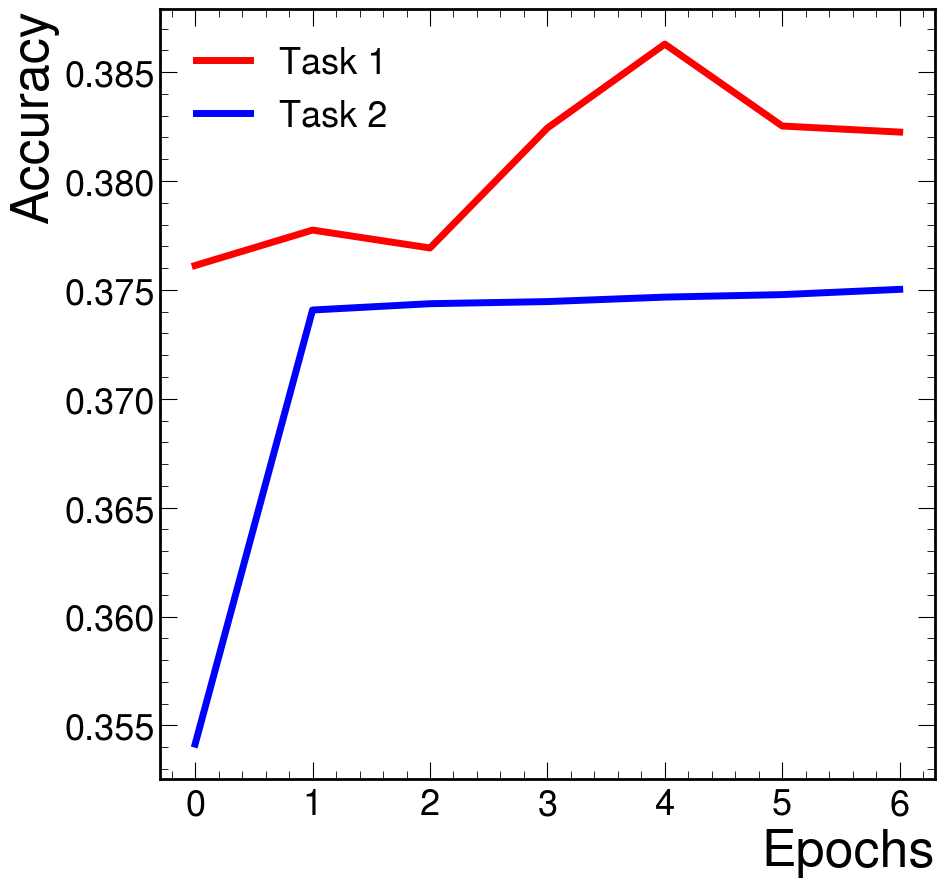


Plotting Accuracy vs Epochs for value of gamma number 0.1111111111111111



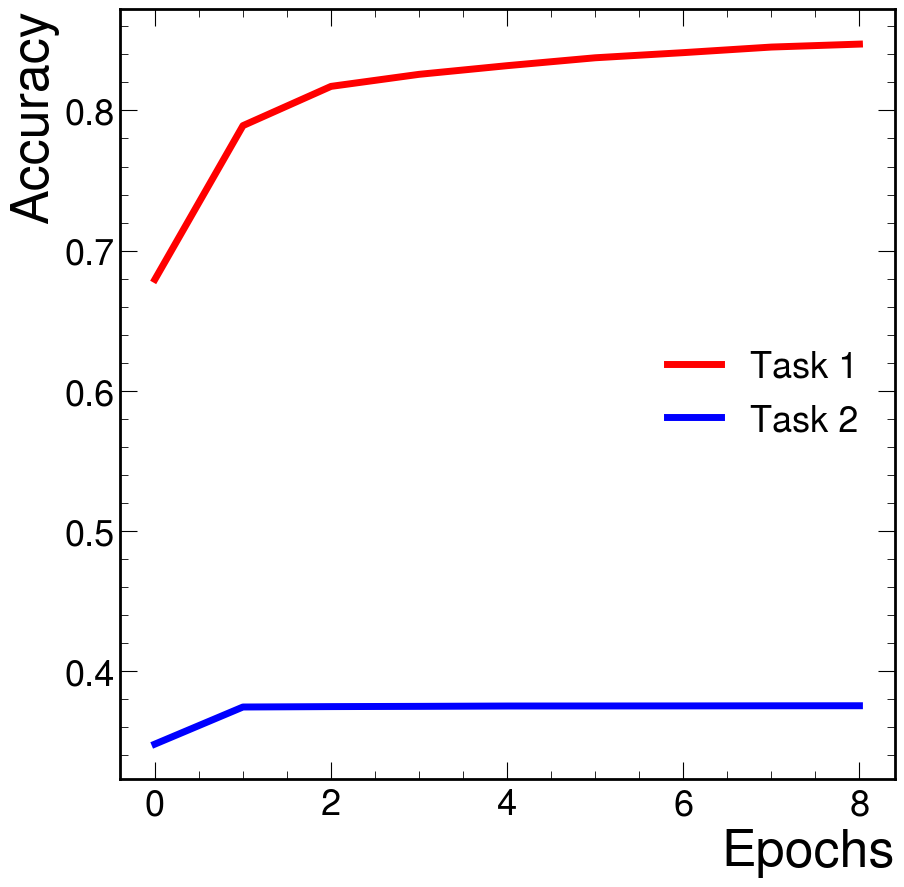


Plotting Accuracy vs Epochs for value of gamma number 0.2222222222222222



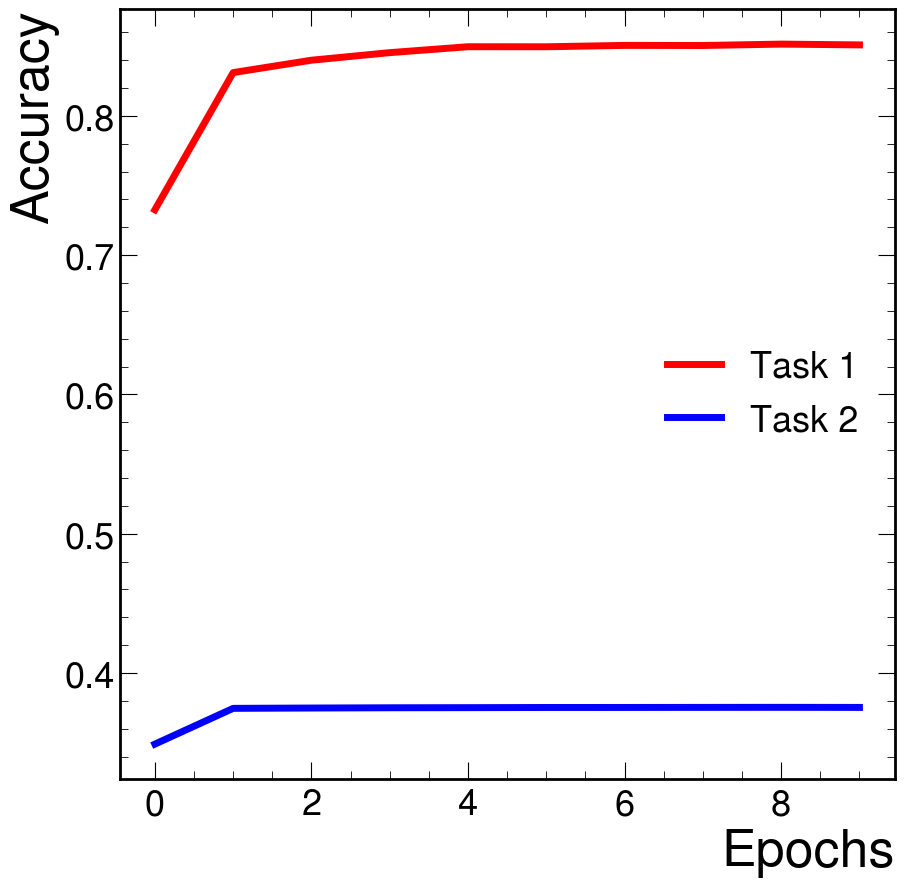


Plotting Accuracy vs Epochs for value of gamma number 0.3333333333333333



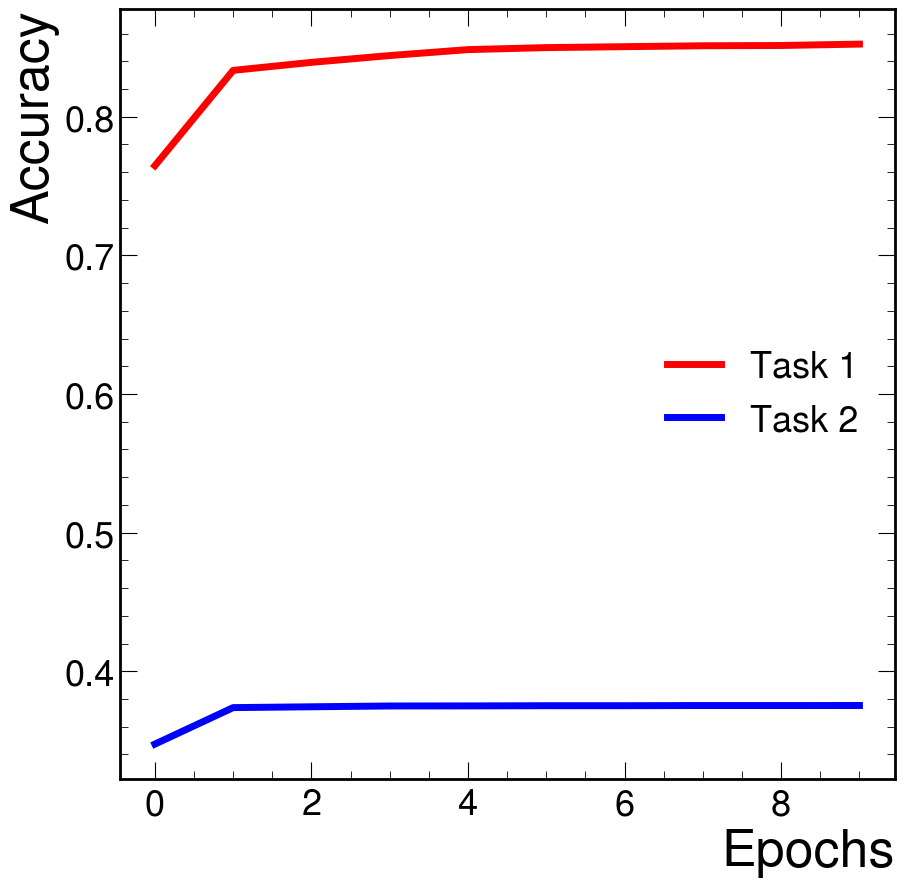


Plotting Accuracy vs Epochs for value of gamma number 0.4444444444444444



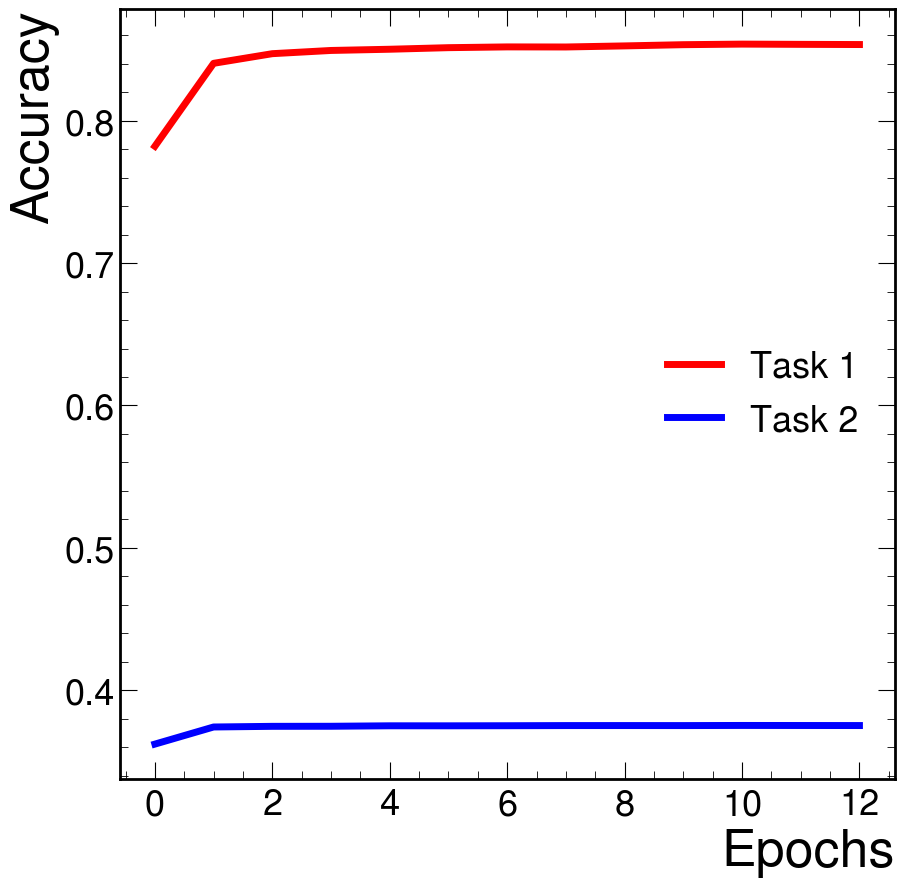


Plotting Accuracy vs Epochs for value of gamma number 0.5555555555555556



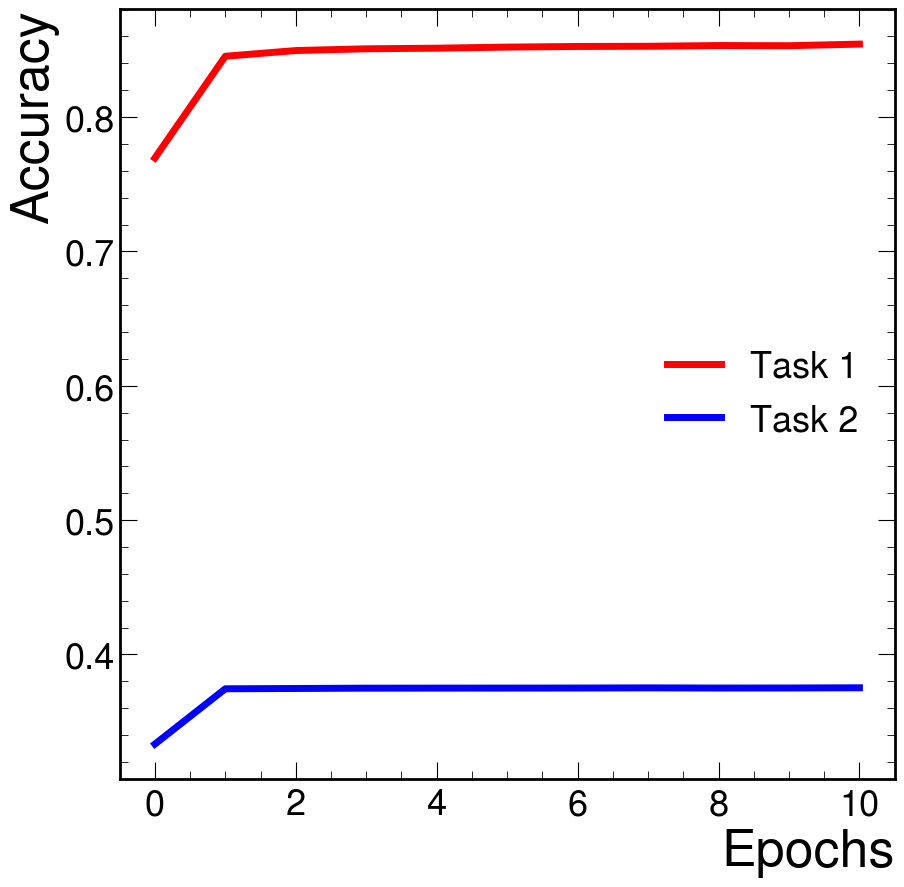


Plotting Accuracy vs Epochs for value of gamma number 0.6666666666666666



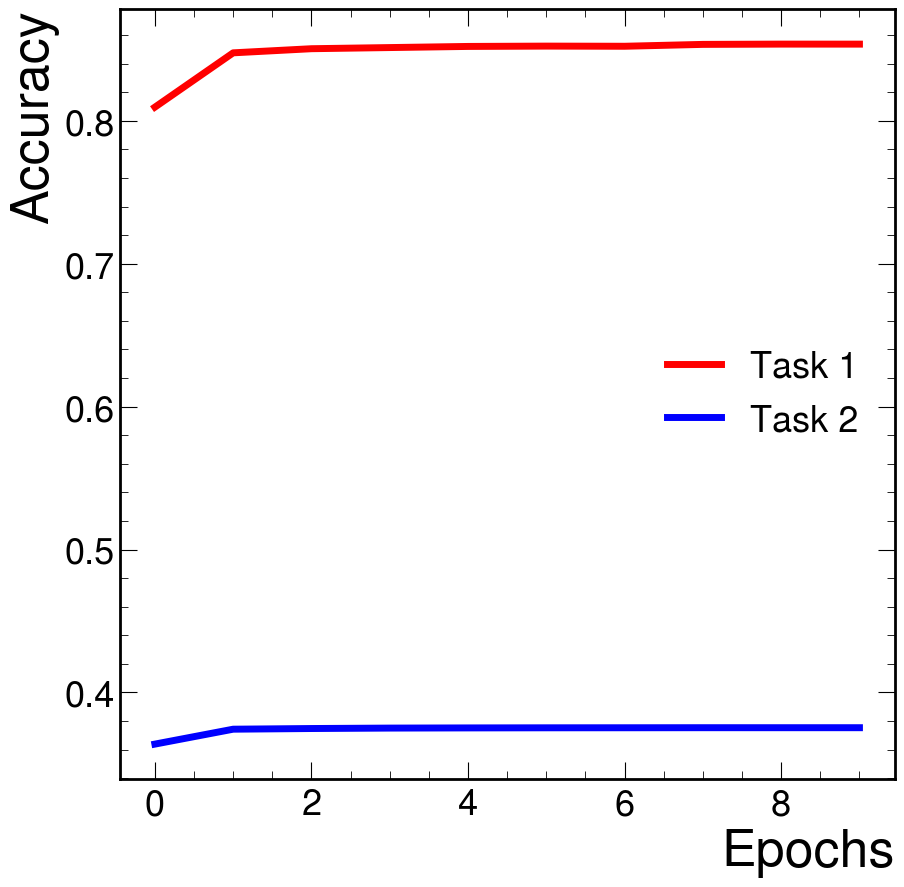


Plotting Accuracy vs Epochs for value of gamma number 0.7777777777777777



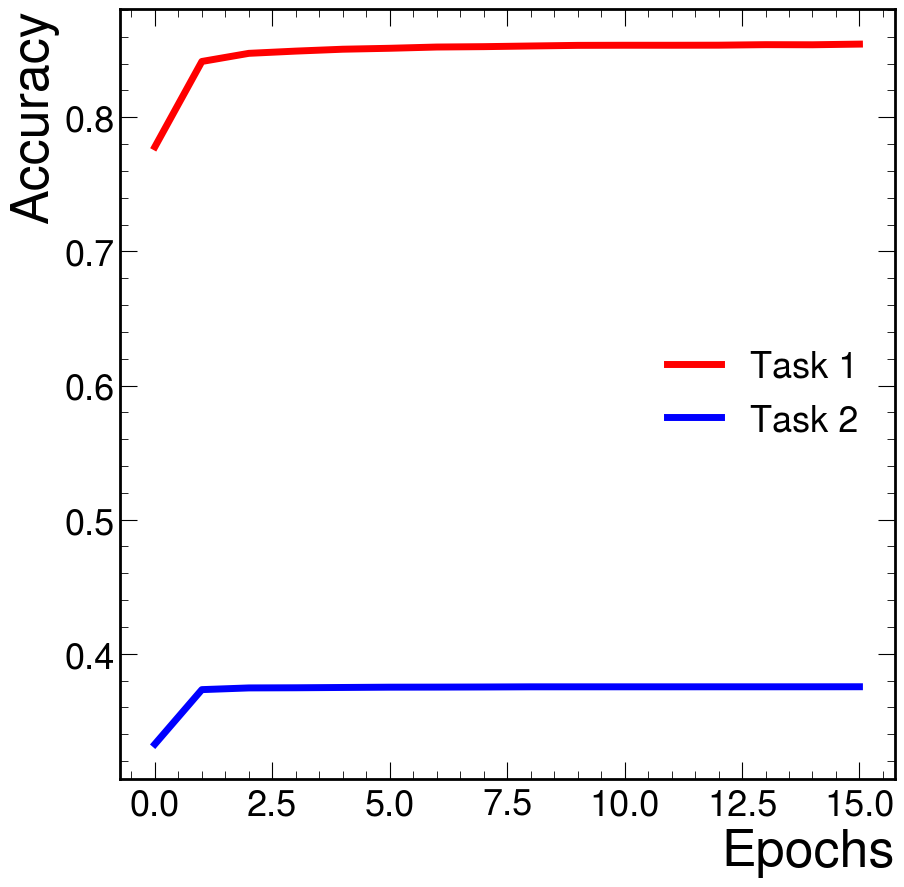


Plotting Accuracy vs Epochs for value of gamma number 0.8888888888888888



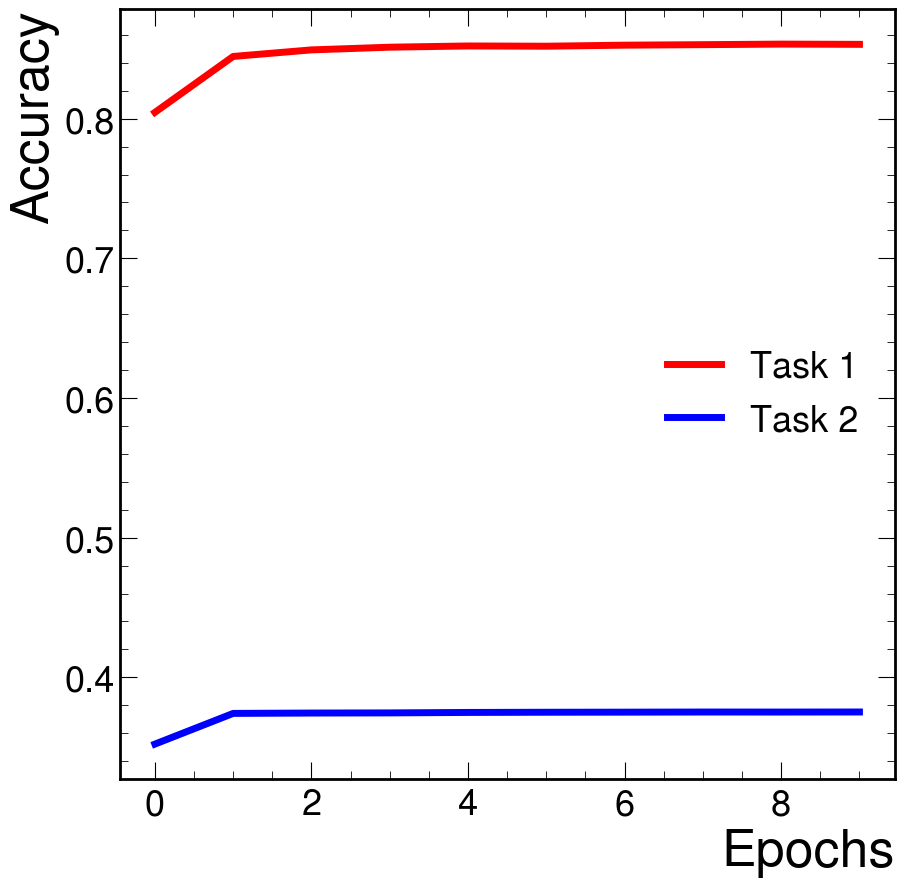


Plotting Accuracy vs Epochs for value of gamma number 1.0



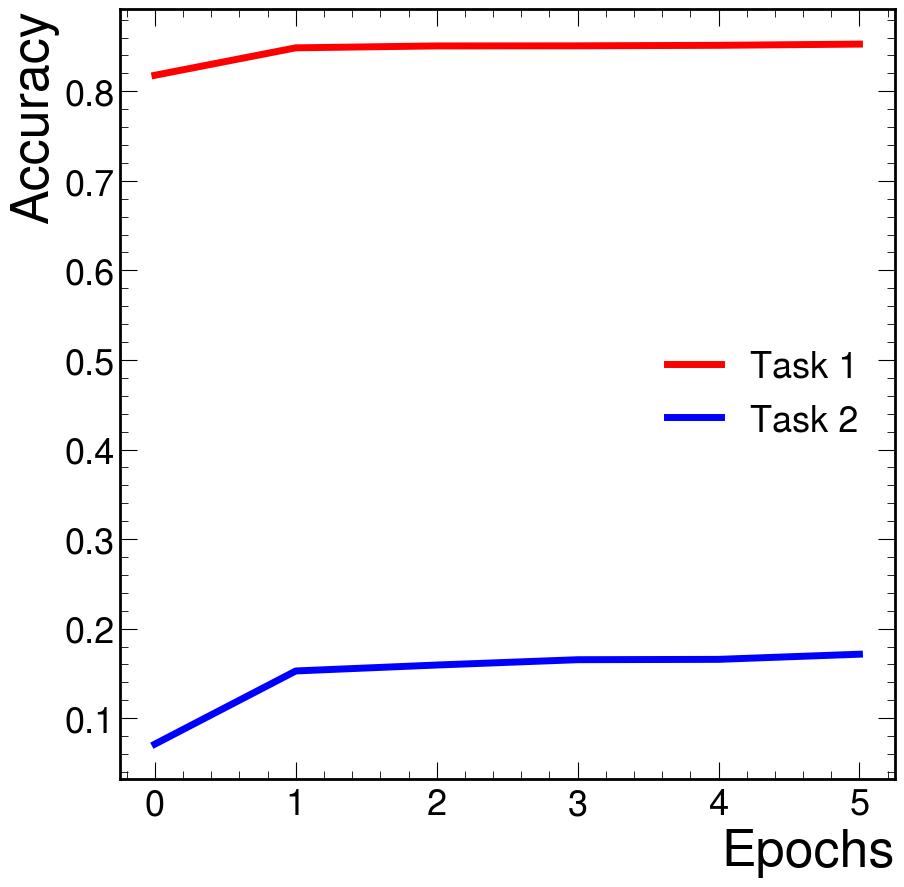

In [16]:
plot_multitask_accuracies(gammas, training_history)


In [17]:
#Load the pts and then plot the actual distributions

In [18]:
def load_and_predict_test(dir_path, model, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    
    X_test = np.asarray(inputs[selection])
    y_pred = model.predict(X_test)[1].flatten() # take the regression output
    print(y_pred)
    pred_pt = np.multiply(reco_pt_selected, y_pred)
    print(pred_pt)
    #Plot the pts
    plt.hist(truth_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Truth', linewidth=5)
    plt.hist(reco_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Reconstructed', linewidth=5)
    plt.hist(pred_pt, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'NN Predicted', linewidth=5)

    plt.xlabel(r'$p_T$ [GeV]')
    plt.ylabel('a.u.')
    plt.legend()  
    plt.show()

2043/2043 [==============================] - 1s 565us/step
[1.172325  1.308098  1.0699875 ... 1.4182805 0.9456    1.182074 ]
[ 70.63258   50.688797 197.4127   ...  63.468052  68.7924    20.095257]


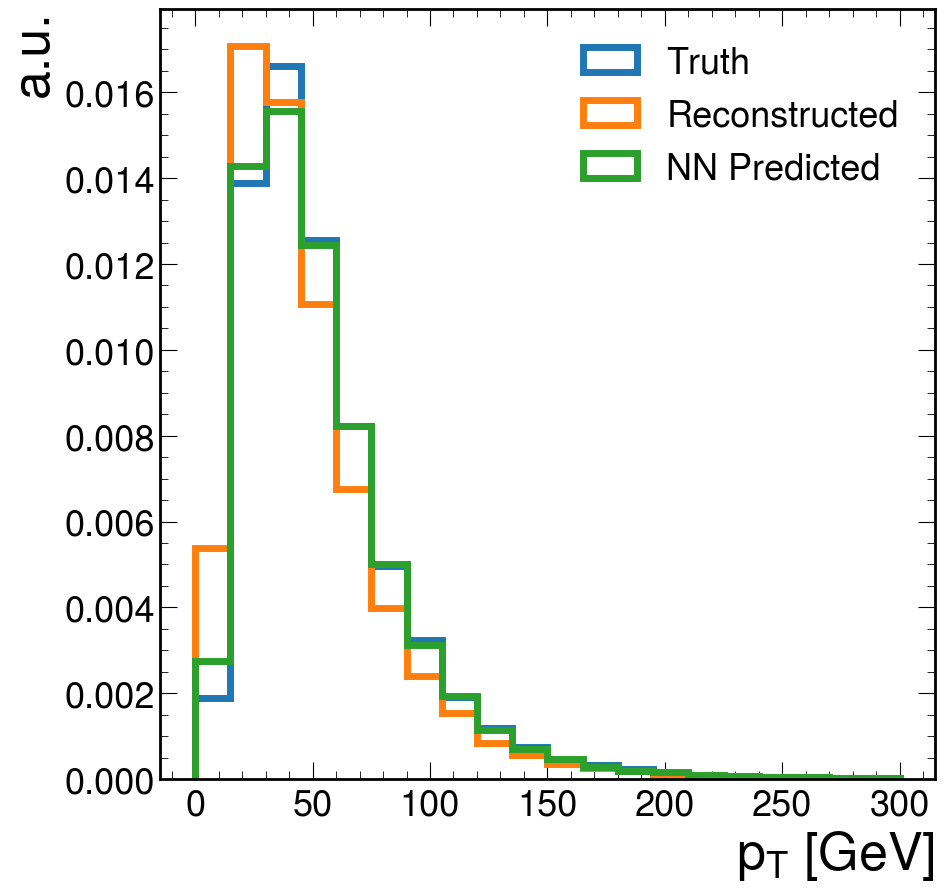

0.0
2043/2043 [==============================] - 1s 563us/step
[1.2475873 1.3152949 1.3572546 ... 1.4438244 1.1598141 1.1912357]
[ 75.16714   50.967674 250.41348  ...  64.611145  84.37648   20.251007]


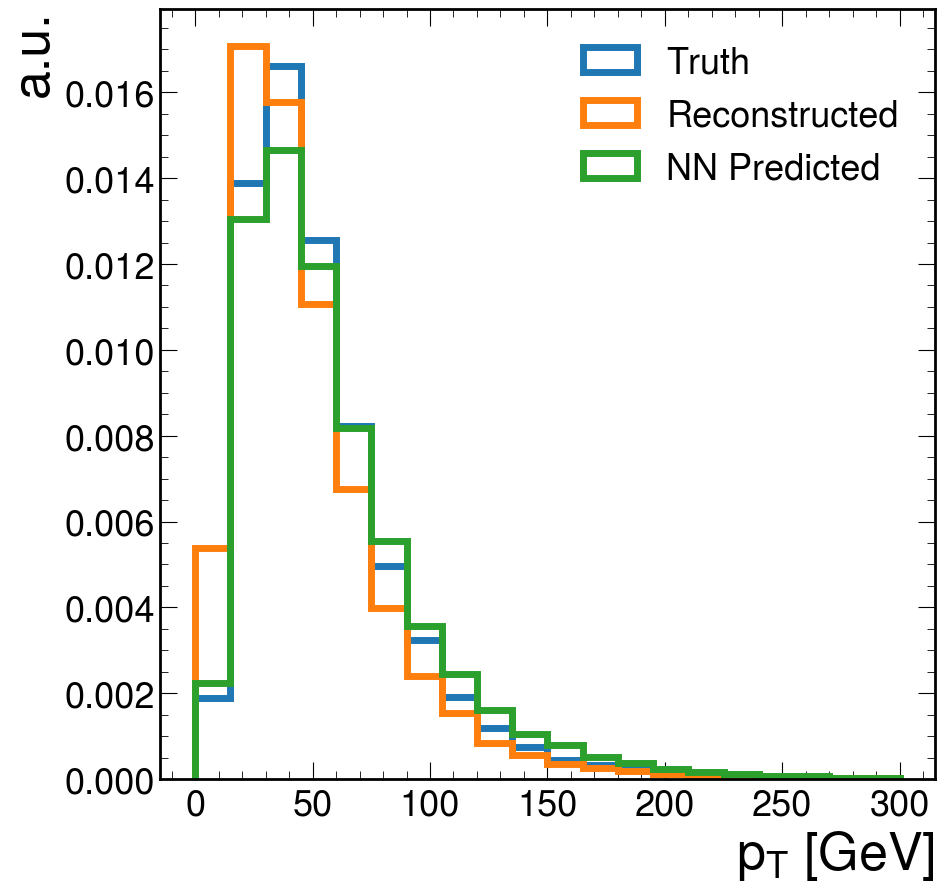

0.1111111111111111
2043/2043 [==============================] - 1s 564us/step
[1.2205224 1.2746468 0.978212  ... 1.318508  0.9945477 1.2533988]
[ 73.536476  49.392563 180.48012  ...  59.003235  72.35335   21.30778 ]


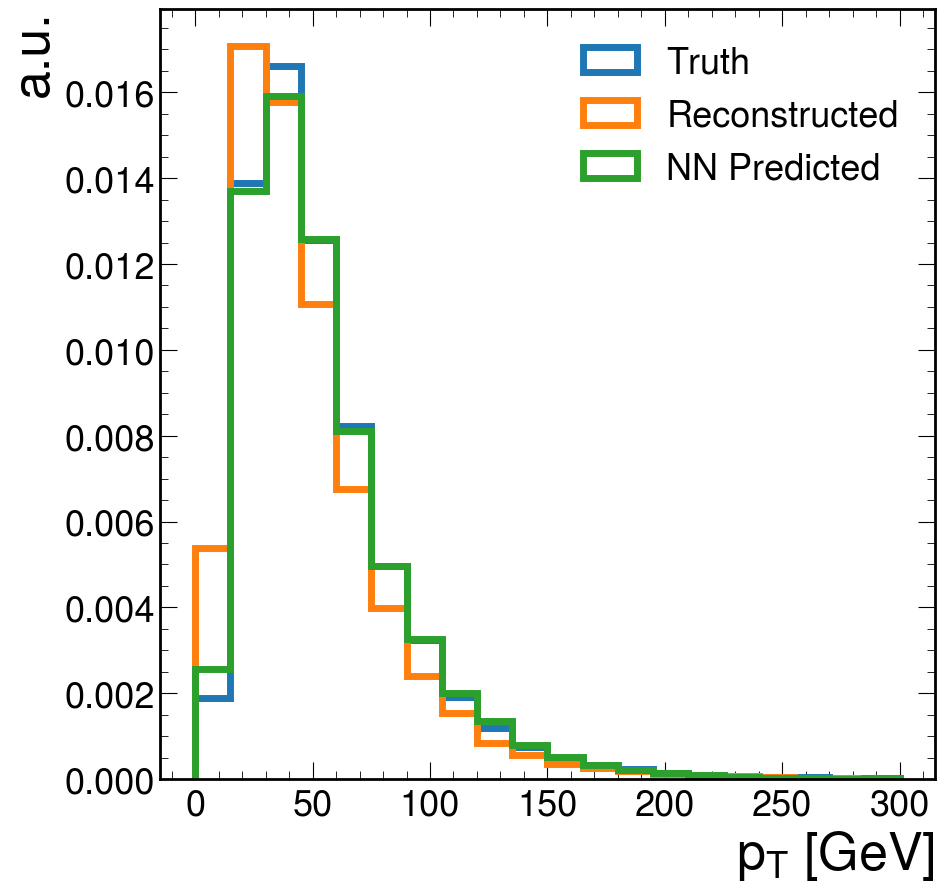

0.2222222222222222
2043/2043 [==============================] - 1s 549us/step
[1.2293137 1.2883035 1.5706818 ... 1.2627016 1.0687168 1.2882175]
[ 74.066154  49.92176  289.7908   ...  56.505898  77.749146  21.899698]


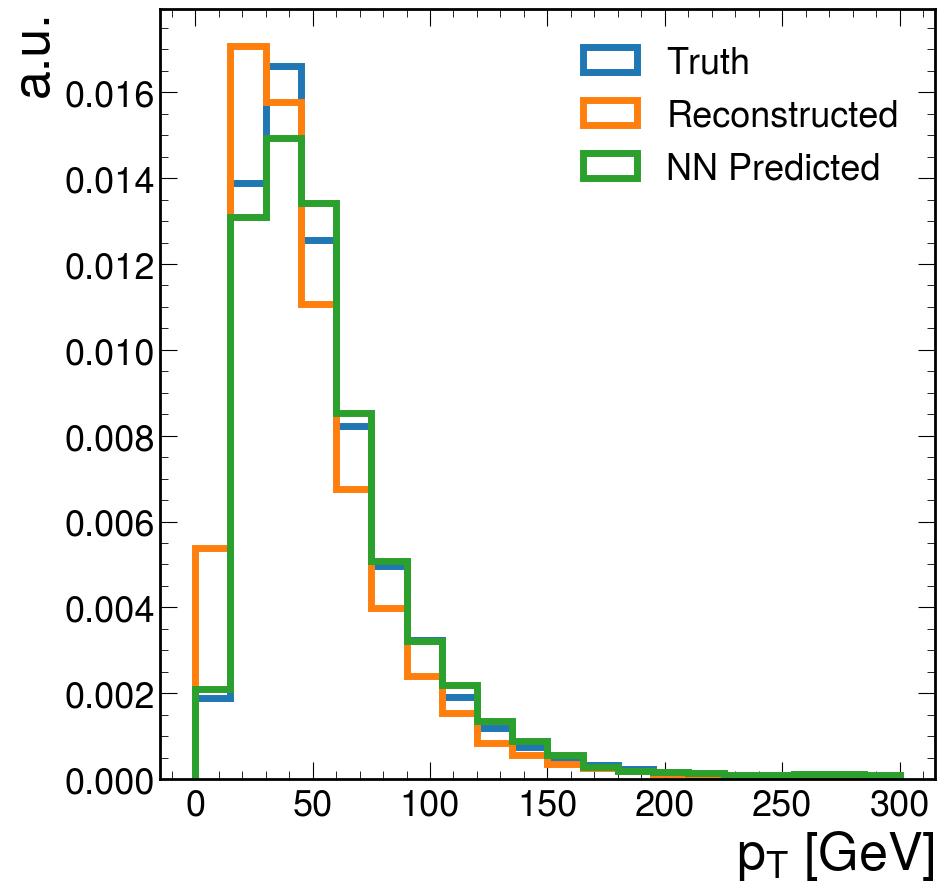

0.3333333333333333
2043/2043 [==============================] - 1s 590us/step
[1.0942261  1.1776813  0.90976846 ... 1.266185   0.9013679  1.1894717 ]
[ 65.927124  45.63515  167.85228  ...  56.66178   65.57452   20.22102 ]


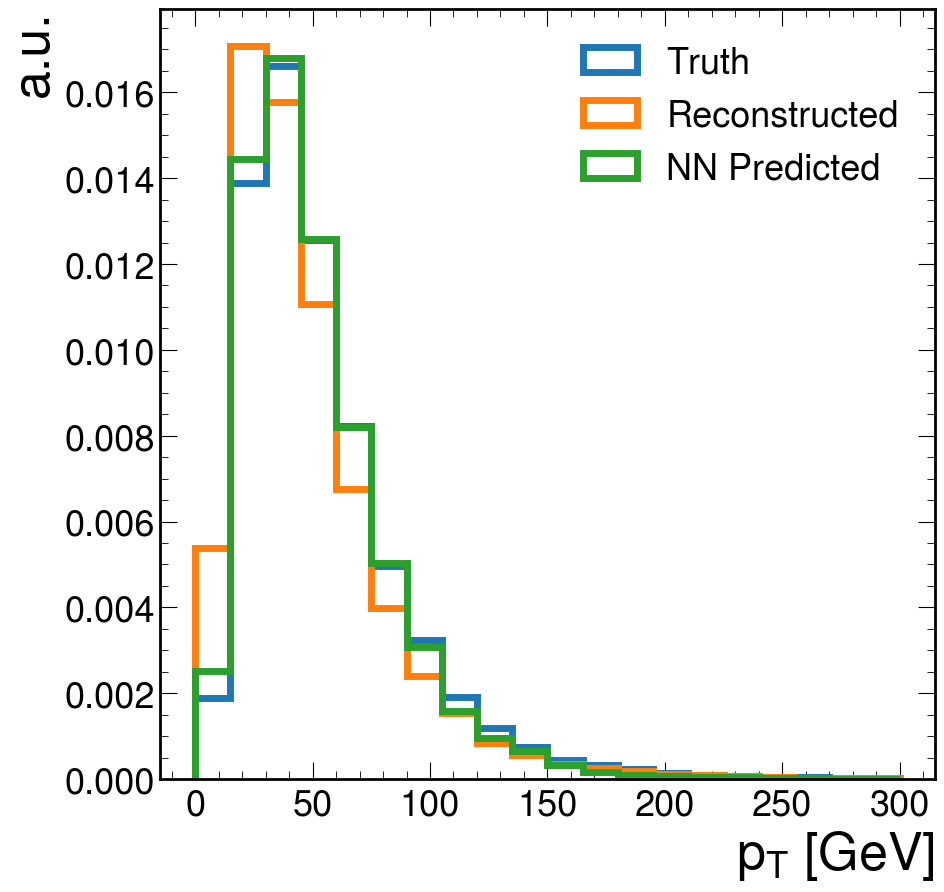

0.4444444444444444
2043/2043 [==============================] - 1s 563us/step
[1.0189579 1.1049571 1.3825508 ... 1.227756  1.0271168 1.074974 ]
[ 61.392212  42.81709  255.08063  ...  54.94208   74.72275   18.274557]


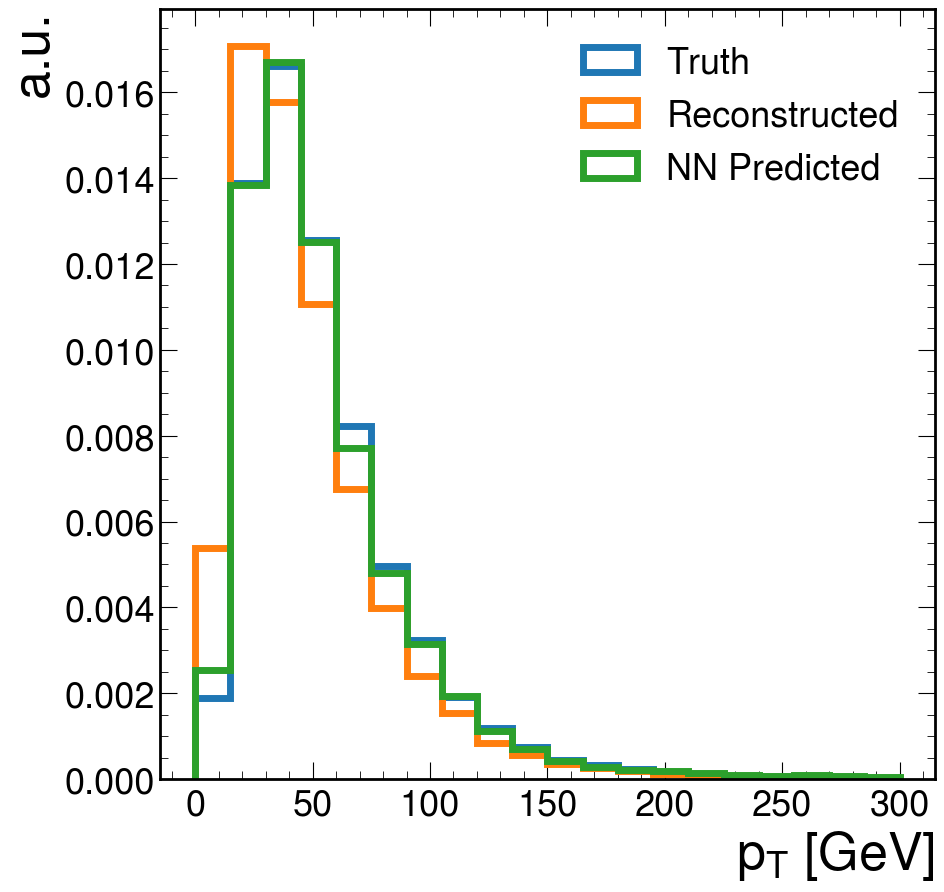

0.5555555555555556
2043/2043 [==============================] - 1s 570us/step
[1.0667505  1.138742   0.8934853  ... 1.1970217  0.99804944 1.154257  ]
[ 64.27172   44.12625  164.84804  ...  53.566723  72.60809   19.62237 ]


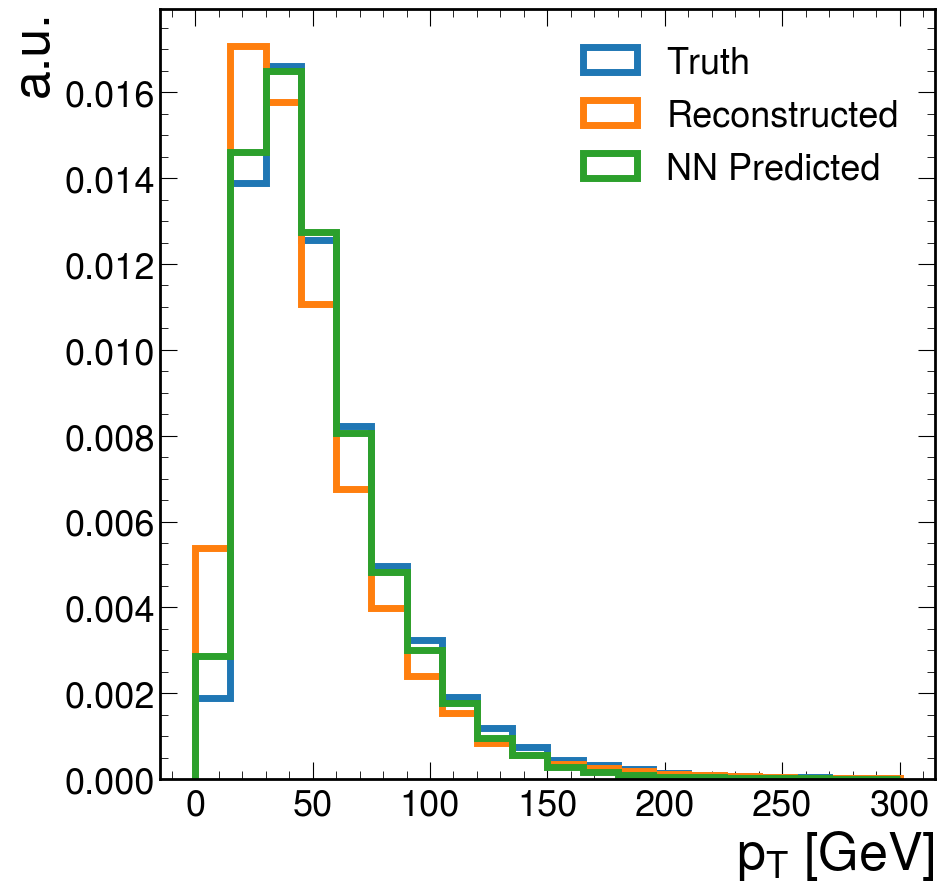

0.6666666666666666
2043/2043 [==============================] - 1s 563us/step
[1.0146898 1.1359872 1.0308893 ... 1.156846  0.886184  1.046957 ]
[ 61.13506  44.0195  190.19907 ...  51.76886  64.46989  17.79827]


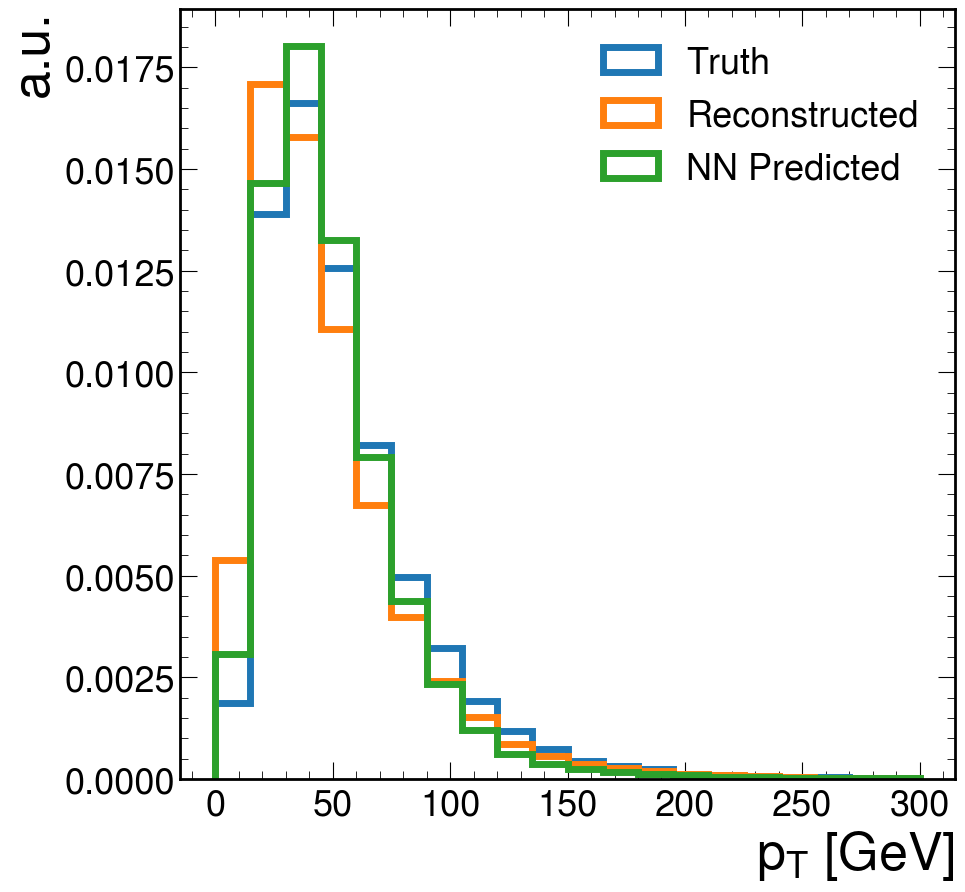

0.7777777777777777
2043/2043 [==============================] - 1s 562us/step
[1.3962362 1.3980982 0.8440056 ... 1.4383649 1.242908  1.2969397]
[ 84.12323   54.176308 155.71902  ...  64.36683   90.421555  22.047976]


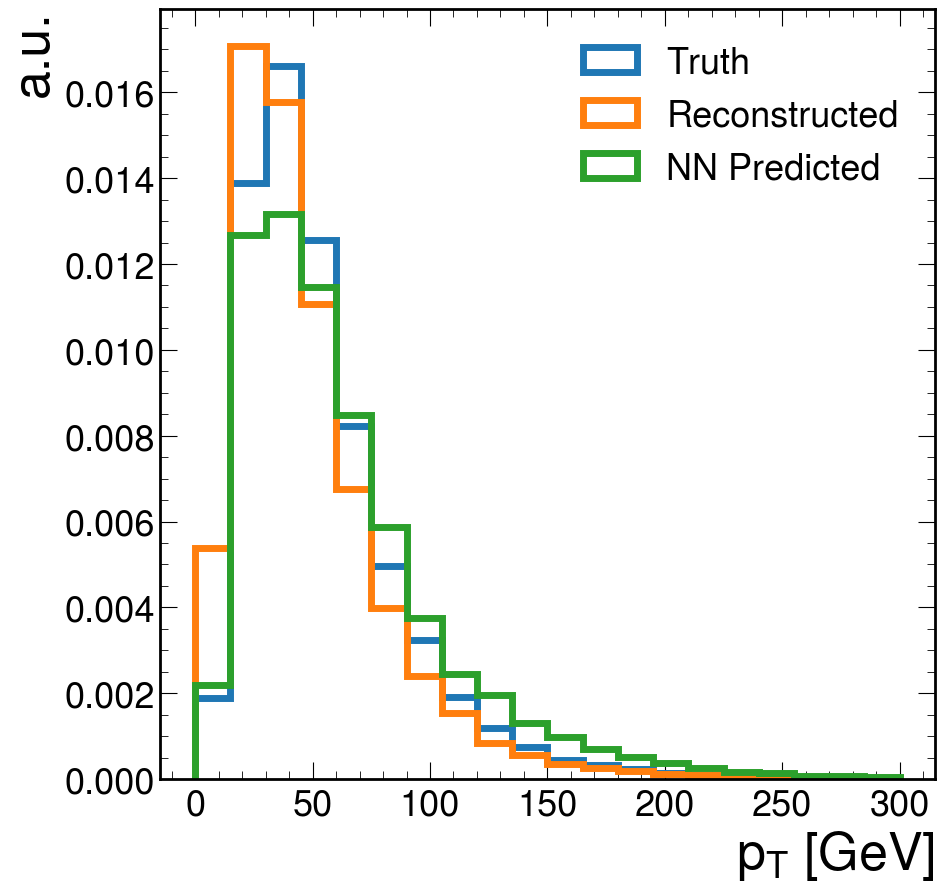

0.8888888888888888
2043/2043 [==============================] - 1s 574us/step
[6.4046025  4.5460124  0.49563313 ... 4.1493983  4.9924583  3.9920337 ]
[385.8773  176.15797  91.44431 ... 185.68558 363.20135  67.86457]


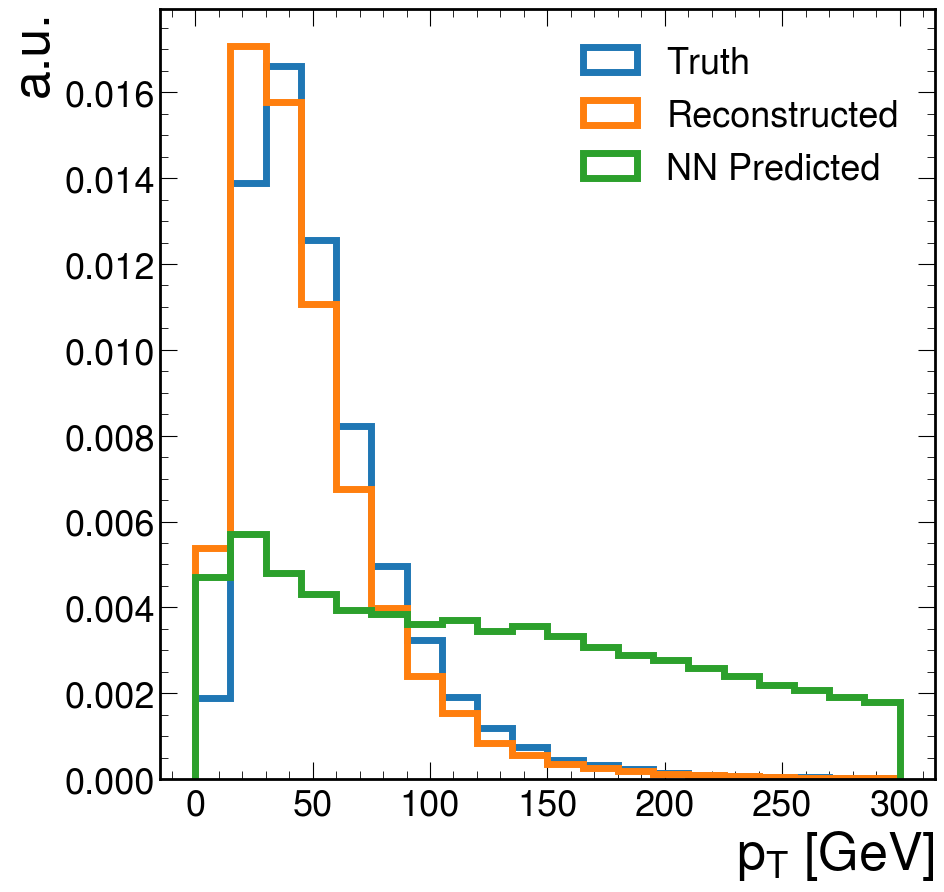

1.0


In [53]:
# load_and_predict_test("../../ntuples/Jan_25_2023", model)
for i in range(len(trained_models)):
    load_and_predict_test("../../ntuples/Jan_25_2023", trained_models[i])
    print(gammas[i])

In [20]:
# Looking nice!! 

## Optimal Gamma using different ROC Curve

11371/11371 [==============================] - 6s 554us/step
[[0.44239125]
 [0.43568698]
 [0.30538657]
 ...
 [0.49444976]
 [0.4183635 ]
 [0.42944843]]
11371/11371 [==============================] - 6s 548us/step
[[0.9994284 ]
 [0.9722624 ]
 [0.97644377]
 ...
 [0.09269436]
 [0.6356592 ]
 [0.5483649 ]]
11371/11371 [==============================] - 7s 590us/step
[[0.99881613]
 [0.9703355 ]
 [0.90809834]
 ...
 [0.02845314]
 [0.71380097]
 [0.53691536]]
11371/11371 [==============================] - 6s 556us/step
[[0.99830544]
 [0.9713092 ]
 [0.99760526]
 ...
 [0.06196347]
 [0.71100885]
 [0.5376575 ]]
11371/11371 [==============================] - 6s 545us/step
[[0.9986835 ]
 [0.9786739 ]
 [0.96732885]
 ...
 [0.04787941]
 [0.67720467]
 [0.5299483 ]]
11371/11371 [==============================] - 6s 559us/step
[[0.9978957 ]
 [0.97737265]
 [0.9760391 ]
 ...
 [0.04681267]
 [0.7489356 ]
 [0.59676933]]
11371/11371 [==============================] - 7s 588us/step
[[0.99588615]
 [0.96242076]
 [0.9

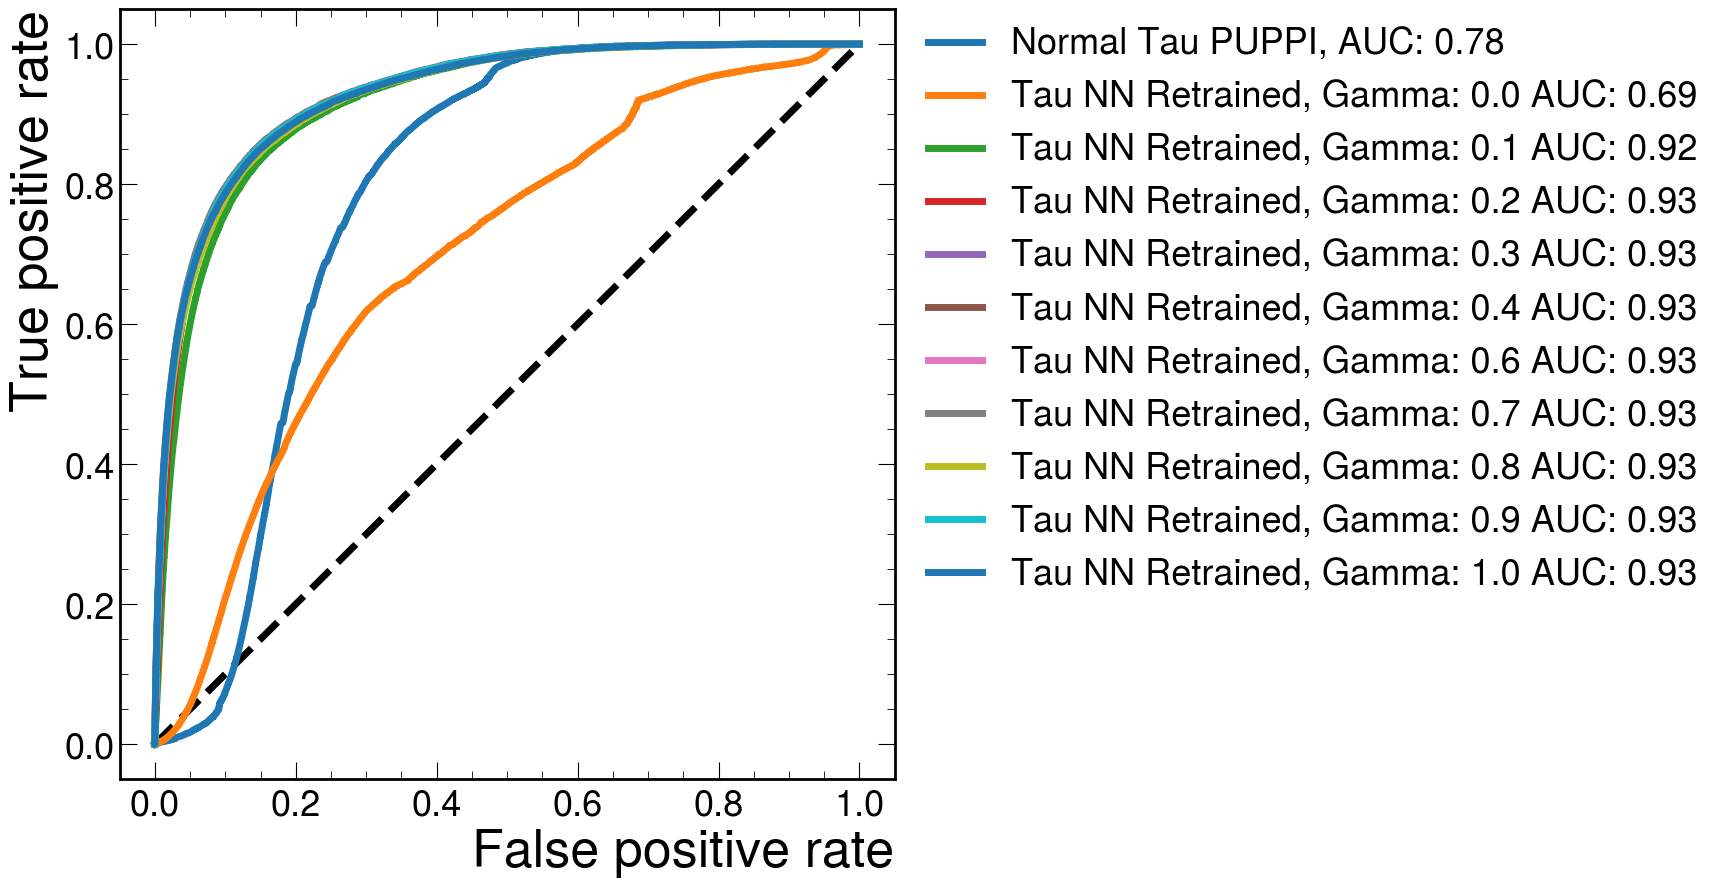

In [21]:
NormalModel = load_model('../../models/Feb_4_2023_JetMetTalk_v1_SigPtTruth20.h5')
#model_id_name = '../../models/Feb_4_2023_JetMetTalk_v1_SigPtTruth20.h5'
# model_pt_regress_name = '../models/merged_pt_regress_jet_ID.h5'
# #model_id = load_model(model_id_name)
# model_train_id = load_model(model_pt_regress_name)


y_pred_normal = NormalModel.predict(X_test)
fpr_normal, tpr_normal, _ = roc_curve(y_test_jetID,y_pred_normal)
#     auc_score_normal = round(auc(fpr_normal, tpr_normal),2)
auc_score_normal = round(auc(fpr_normal, tpr_normal), 2)
#Create plot for ROC
plt.figure(1)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_normal, tpr_normal, label = 'Normal Tau PUPPI, AUC: {}'.format(auc_score_normal))
#Establish labels and save image
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

    
for i in range(len(trained_models)):
    y_pred_mono = trained_models[i].predict(X_test)[0]
    print(y_pred_mono)
    fpr_mono, tpr_mono, _ = roc_curve(y_test_jetID, y_pred_mono)
#     auc_score_mono = round(auc(fpr_mono, tpr_mono),2)
    auc_score_mono = round(auc(fpr_mono, tpr_mono), 2)



   
    plt.plot(fpr_mono, tpr_mono, label = 'Tau NN Retrained, Gamma: ' + str(round(gammas[i], 1)) + ' AUC: {}'.format(auc_score_mono))

  
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

## Scanning Optimal Gamma using ROC Curve

In [56]:
model_id_name = '../../models/Feb_4_2023_JetMetTalk_v1_SigPtTruth20.h5'
model_pt_regress_name = '../models/merged_pt_regress_jet_ID.h5'
model_id = load_model(model_id_name)
#MinBias_nn_score_model = model_id.predict(MinBias_inputs)

model_regress = load_model(model_pt_regress_name)
#MinBias_nn_selected_pt_ratio = model_regress.predict(MinBias_inputs).flatten()

In [60]:
def prep_rate_data(NormalModelID, 
                   ModelNameID,
             ModelNameRegress,
             truth_sig_pt_cut=50,
             minbias_pt_cut_value=50,
             minbias_path = "../../ntuples/Jan_25_2023/test_bkg_v12_emseed.root",
             sig_path = "../../ntuples/Jan_25_2023/test_sig_v12_emseed.root",
             TreeName='ntuplePupSingle',
             test_index=400000):
    
    
    modelID = load_model(NormalModelID)
    
    #Load the data
    MinBias = uproot4.open(minbias_path)
    sig = uproot4.open(sig_path)
    
    #Signal data prep
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])
    sig_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[test_index:][selection_sig])
    sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][selection_sig])      
    
    #Pick out unique events
    minbias_id, minbias_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()[test_index:]), return_index=True)
    sig_id_temp, sig_index_temp = np.unique(sig_id, return_index=True)
    
    true_sig_id, _, true_signal_index = np.intersect1d(np.unique(minbias_id), np.unique(sig_id_temp), return_indices=True)
    
    #True signal data preparation (these are events that actually overlaps with MinBias)
    true_sig_pt = sig_pt[sig_index_temp][true_signal_index]
    true_sig_input = sig_input[sig_index_temp][true_signal_index]
    true_sig_score = modelID.predict(true_sig_input).flatten()
    
    minbias_pt = MinBias['ntuplePupSingle']['tree']['pt'].array()[test_index:][minbias_index]
    minbias_input = np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][minbias_index])
    minbias_input[abs(minbias_input) > 1e+9] = 0.

    minbias_score = modelID.predict(minbias_input).flatten()
    
    #
    sig_pt_cut = true_sig_pt > minbias_pt_cut_value
    minbias_pt_cut = minbias_pt > minbias_pt_cut_value
    
    true_sig_score_pt = true_sig_score[sig_pt_cut]
    minbias_score_pt = minbias_score[minbias_pt_cut]
    
    #Now apply correction
    #model_regress = load_model(ModelNameRegress)
    
    #minbias_pt_corrected_ratio = model_regress.predict(minbias_input).flatten()
    #minbias_pt_corrected = np.multiply(minbias_pt, minbias_pt_corrected_ratio)

    #true_sig_pt_corrected_ratio = model_regress.predict(true_sig_input).flatten()
    #true_sig_pt_corrected = np.multiply(true_sig_pt, true_sig_pt_corrected_ratio)
    
    #sig_pt_cut_corrected = true_sig_pt_corrected > minbias_pt_cut_value
    #minbias_pt_cut_corrected = minbias_pt_corrected > minbias_pt_cut_value
    
    #true_sig_score_pt_corrected = true_sig_score[sig_pt_cut_corrected]
    #minbias_score_pt_corrected = minbias_score[minbias_pt_cut_corrected]
    
    n_event = minbias_index.shape[0]
    n_sig_event = true_sig_id.shape[0]
    
    ##LOOP to calculate the ROC curves
    tau_score_edges = [round(i,2) for i in np.arange(0, 0.8, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

    sig_list = []
    bkg_list = []

    for tau_score_cut in tau_score_edges:
    
        bkg_pass = sum(minbias_score_pt>tau_score_cut)
        sig_pass = sum(true_sig_score_pt>tau_score_cut)
        
        sig_list.append(sig_pass/n_sig_event)
        bkg_list.append(bkg_pass/n_event)

    
    bkg_list_scaled = [i*(32e+3) for i in bkg_list]
    
    
    plt.plot(sig_list, bkg_list_scaled, label=r'Tau NN ID (No $p_T$ Correction)',linewidth=5)
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    #Load the data
    MinBias = uproot4.open(minbias_path)
    sig = uproot4.open(sig_path)
    
    #Signal data prep
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])
    sig_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[test_index:][selection_sig])
    sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][selection_sig])      
    
    #Pick out unique events
    minbias_id, minbias_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()[test_index:]), return_index=True)
    sig_id_temp, sig_index_temp = np.unique(sig_id, return_index=True)
    
    true_sig_id, _, true_signal_index = np.intersect1d(np.unique(minbias_id), np.unique(sig_id_temp), return_indices=True)
    
    #True signal data preparation (these are events that actually overlaps with MinBias)
    true_sig_pt = sig_pt[sig_index_temp][true_signal_index]
    true_sig_input = sig_input[sig_index_temp][true_signal_index]
    for i in range(len(ModelNameID)):
        modelID = ModelNameID[i]
        true_sig_score = modelID.predict(true_sig_input)[0].flatten()

        minbias_pt = MinBias['ntuplePupSingle']['tree']['pt'].array()[test_index:][minbias_index]
        minbias_input = np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][minbias_index])
        minbias_input[abs(minbias_input) > 1e+9] = 0.

        minbias_score = modelID.predict(minbias_input)[0].flatten()

        #
        sig_pt_cut = true_sig_pt > minbias_pt_cut_value
        minbias_pt_cut = minbias_pt > minbias_pt_cut_value

        true_sig_score_pt = true_sig_score[sig_pt_cut]
        minbias_score_pt = minbias_score[minbias_pt_cut]

        #Now apply correction
    #     for i in range(len(ModelNameRegress)):
        #model_regress = load_model(ModelNameRegress)
        model_regress = ModelNameRegress[i]

        minbias_pt_corrected_ratio = model_regress.predict(minbias_input)[1].flatten()
        minbias_pt_corrected = np.multiply(minbias_pt, minbias_pt_corrected_ratio)

        true_sig_pt_corrected_ratio = model_regress.predict(true_sig_input)[1].flatten()
        true_sig_pt_corrected = np.multiply(true_sig_pt, true_sig_pt_corrected_ratio)

        sig_pt_cut_corrected = true_sig_pt_corrected > minbias_pt_cut_value
        minbias_pt_cut_corrected = minbias_pt_corrected > minbias_pt_cut_value

        true_sig_score_pt_corrected = true_sig_score[sig_pt_cut_corrected]
        minbias_score_pt_corrected = minbias_score[minbias_pt_cut_corrected]

        n_event = minbias_index.shape[0]
        n_sig_event = true_sig_id.shape[0]

        ##LOOP to calculate the ROC curves
        tau_score_edges = [round(i,2) for i in np.arange(0, 0.8, 0.01).tolist()]+\
                      [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

        sig_list_corrected = []
        bkg_list_corrected = []

        for tau_score_cut in tau_score_edges:
            bkg_pass = sum(minbias_score_pt_corrected>tau_score_cut)
            sig_pass = sum(true_sig_score_pt_corrected>tau_score_cut)

            sig_list_corrected.append(sig_pass/n_sig_event)
            bkg_list_corrected.append(bkg_pass/n_event)

        bkg_list_scaled_corrected = [i*(32e+3) for i in bkg_list_corrected]

        plt.plot(sig_list_corrected, bkg_list_scaled_corrected, label=r'Tau NN ID ($p_T$ Correction), $\gamma=$' + str(round(gammas[i], 1)),linewidth=2)
        hep.cms.text("Phase 2 Simulation")
        hep.cms.lumitext("PU 200 (14 TeV)")

        plt.ylabel(r'$Single \tau_h$ Trigger Rate [kHz]')
        plt.xlabel(r'$\tau_h$ [$p_T^{gen} > % d$ GeV]' %int(truth_sig_pt_cut))

        plt.yscale('log')
        #plt.legend(loc='best',fontsize=20)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
    plt.plot([],[], 'none', label=r'(MinBias $p_T^{reco (or~corrected)}$ >  % d GeV)'%int(minbias_pt_cut_value))
    plt.show()

    return n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected


115/115 [==============================] - 0s 600us/step


/tmp/ipykernel_2758722/1719815670.py:197: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,10e+2])


115/115 [==============================] - 0s 587us/step


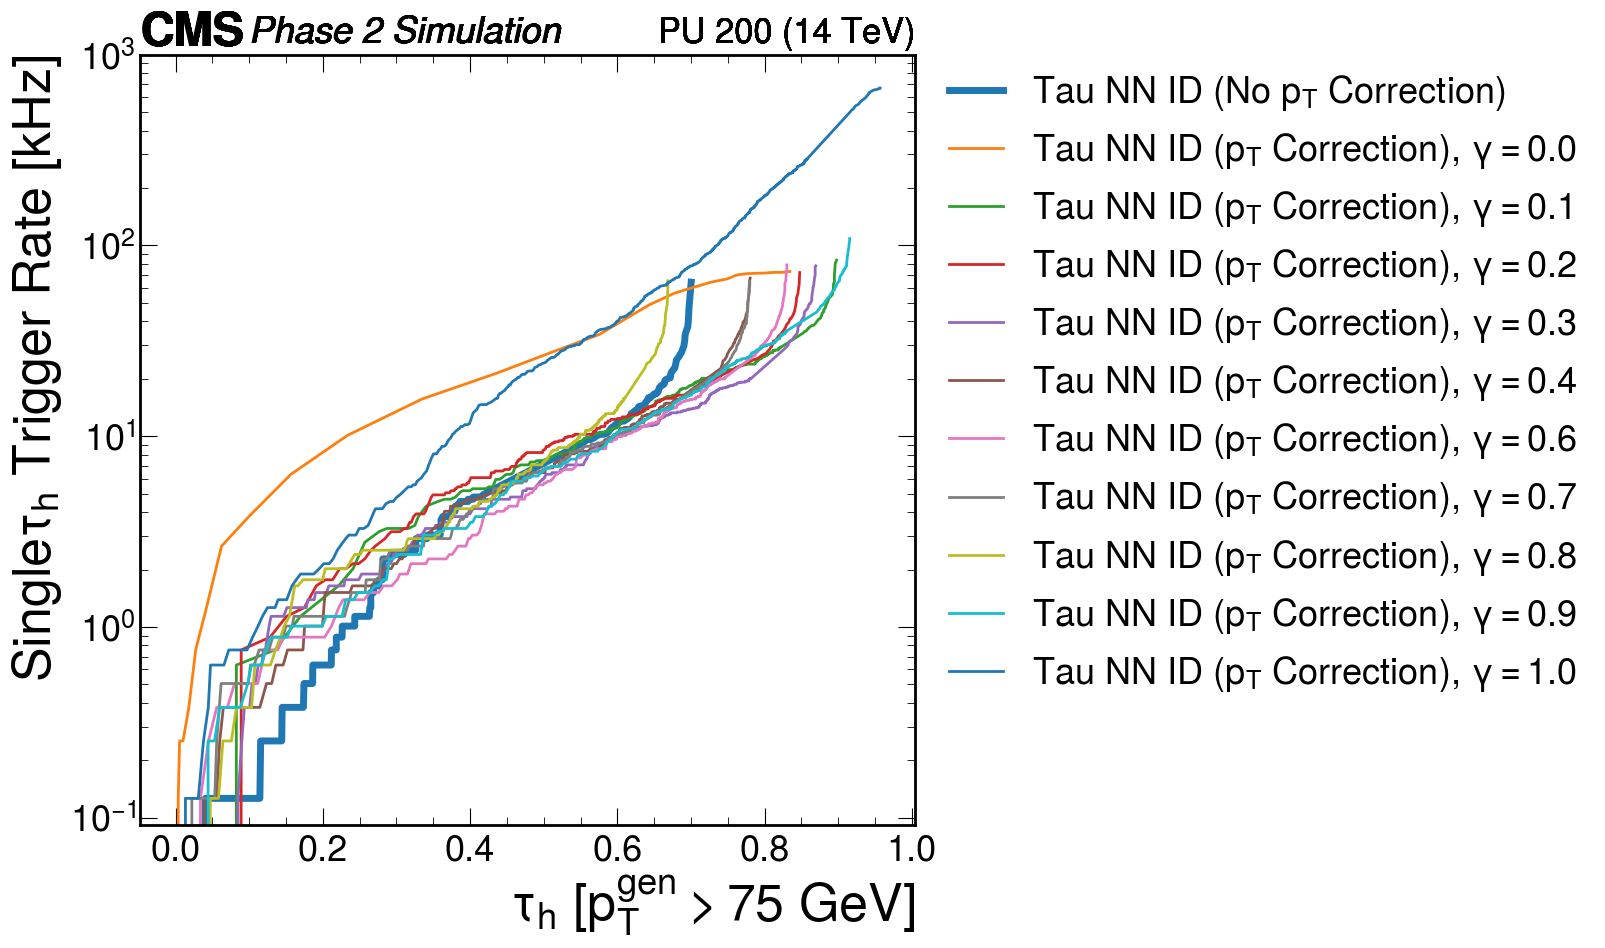

In [61]:
# n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected = prep_rate_data(model_id_name,
#                                                                                                                                     trained_models,
#                                                                                                                                     truth_sig_pt_cut=75,
#                                                                                                                                     minbias_pt_cut_value=75)

n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected = prep_rate_data(model_id_name,
                                                                                                                                    trained_models,
                                                                                                                                    trained_models,
                                                                                                                                    truth_sig_pt_cut=75,
                                                                                                                                    minbias_pt_cut_value=75)

### Resolution + Response Plots

In [28]:
def bob(dir_path, model, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    
    X_test = np.asarray(inputs[selection])
    y_pred = trained_models[3].predict(X_test)[1].flatten()
    pred_pt = np.multiply(reco_pt_selected, y_pred)
    
    residual = pred_pt - truth_pt_selected
    print(min(residual))
    print(max(residual))
    plot_bins = 200
    plot_range = (-125, 75)
    p_guess=[10, 0, 0.01]
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         density = True)
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, _ = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False)
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    #Plot fitted gaussian
    plt.plot(bins,
             fit_function(bins, *popt),
             "r-",
             linewidth=4,
             label='Best fit')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.4f$'%abs(popt[2]))
    
    plt.xlabel("$p_T^{PUPPI} - p_T^{gen}$ [GeV]", fontsize = 27)
    plt.ylabel('Normalized counts')

    plt.legend()


2043/2043 [==============================] - 1s 551us/step
-563.98364
4739.7017
Error for parameter esimations:  [0.00145189 0.254127   0.2238633 ]
Standard deviation (fit) is 9.017490456185078
Mean (fit) is 2.7807917886821842


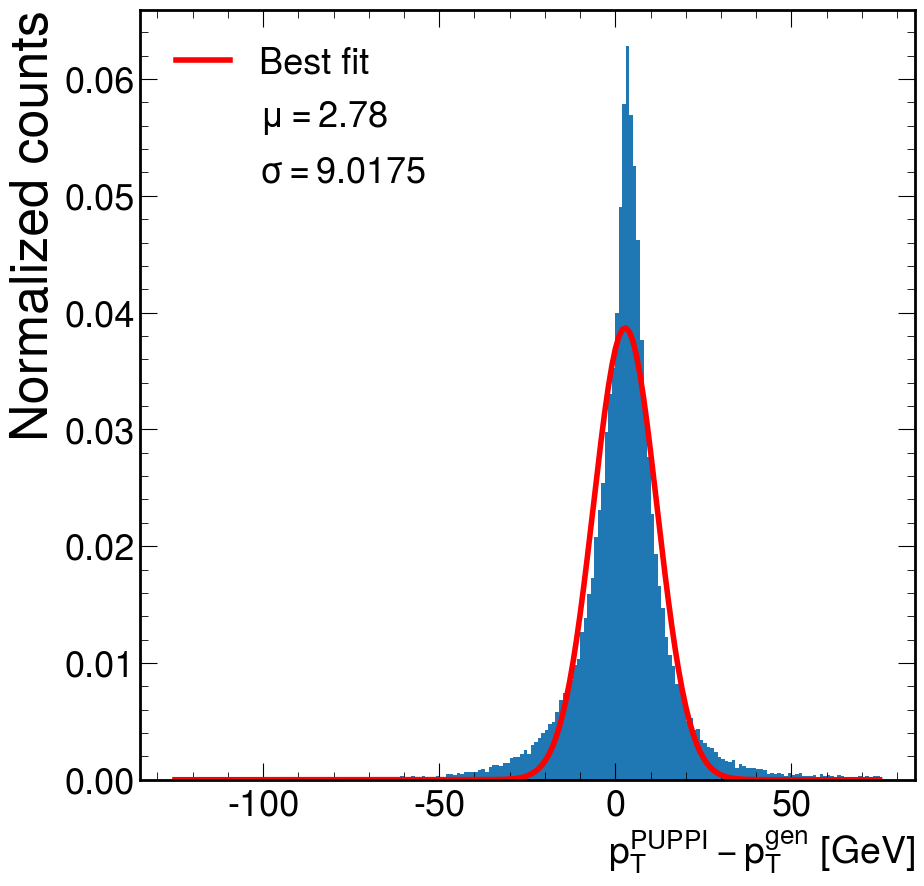

In [29]:
bob("../../ntuples/Jan_25_2023", trained_models[7])